## Análise Exploratória do Conjunto de Dados

### Sumário <a class="anchor" id="topo"></a>

* [Parte 1: Configuração do notebook](#part_01)
* [Parte 2: Geração do arquivo .csv](#part_02)
* [Parte 3: Análise exploratória dos dados](#part_03)

### Parte 1: Configuração do notebook <a class="anchor" id="part_01"></a>

Nesta seção, as bibliotecas que serão usadas são importadas e as variáveis globais são definidas.

In [31]:
import csv
import os

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

tqdm.pandas()

PATH_TO_DATASET = "/home/lozavival/Documents/AUDIOS-Dataset/release/"

print("Done!")

Done!


### Parte 2: Geração do arquivo .csv <a class="anchor" id="part_02"></a>

Nesta seção, a estrutura de pastas do dataset é percorrida para criação de um arquivo .csv contendo informações de metadados dos arquivos presentes no dataset.

Esse arquivo pode ser gerado em duas versões: uma listagem por pessoa, em que cada linha da tabela contém informações sobre um locutor, ou uma listagem por arquivo, em que cada linha da tabela contém informações sobre um arquivo de áudio específico.

listagem por arquivo, em que cada linha da tabela contém informações sobre um arquivo de áudio específico.

#### Versão 1: Listagem por Pessoa

Aqui, o dataset é percorrido e é gerado um arquivo .csv com as seguintes informações de cada pessoa:

* Nome
* Código identificador
* Gênero (extraído do código identificador)
* Quantidade de arquivos de fala sintetizada
* Quantidade de arquivos de fala real

In [ ]:
# Create a dictionary containing the name, id, gender and number of spoofed
# and bonafide files for each person.
fake_audios_path = os.path.join(PATH_TO_DATASET, "fake_voices")
real_audios_path = os.path.join(PATH_TO_DATASET, "real_voices")
people = {}

# For every spoofed folder, get the number of spoofed files
for folder in os.listdir(fake_audios_path):
    path = os.path.join(fake_audios_path, folder)
    files = os.listdir(path)

    person, ids, *_ = folder.split("_")
    gender = ids[0]

    people[person] = {
        "gender": gender,
        "id": ids,
        "spoof_count": len(files),
    }

# For every bona-fide folder, get the number of bona-fide files
for folder in os.listdir(real_audios_path):
    path = os.path.join(real_audios_path, folder)
    files = os.listdir(path)

    person, ids, *_ = folder.split("_")
    gender = ids[0]

    if people.get(person) is not None:
        people[person]["bonafide_count"] = len(files)
    else:
        # If the person is not in the dictionary, there are no spoof files
        people[person] = {
            "gender": gender,
            "id": ids,
            "spoof_count": 0,
            "bonafide_count": len(files),
        }

print(len(people))
print(list(people.items())[:5])

In [ ]:
# Export the dictionary to a .csv file.

fields = ["person", "gender", "id", "spoof_count", "bonafide_count"]
with open(os.path.join(PATH_TO_DATASET, "meta.csv"), "w") as f:
    writer = csv.writer(f)
    writer.writerow(fields)
    for person, data in people.items():
        writer.writerow([person, data["gender"], data["id"], data["spoof_count"], data["bonafide_count"]])

print("File written!")

#### Versão 2: Listagem por Arquivo

O dataset é percorrido e é gerado um arquivo .csv com as seguintes informações de cada arquivo de áudio:

* Caminho relativo do arquivo no dataset
* Nome do locutor
* Código identificador do locutor
* Gênero do locutor (extraído de seu código identificador)
* Duração do áudio (em segundos)
* Rótulo do áudio ("spoof" ou "bona-fide")

In [ ]:
# Function to get the duration of an audio
def get_duration(filename):
    try:
        audio_path = os.path.join(PATH_TO_DATASET, filename)
        y, sr = librosa.load(audio_path, sr=None)
        return librosa.get_duration(y=y, sr=sr)
    except Exception as e:
        print(f"Could not load file {filename}: {e}")
        return None

# Function to get the amplitude of an audio
def get_amplitude(filename):
    try:
        audio_path = os.path.join(PATH_TO_DATASET, filename)
        y, sr = librosa.load(audio_path, sr=None)
        return np.max(np.abs(y))
    except Exception as e:
        print(f"Could not load file {filename}: {e}")
        return None

In [ ]:
# Create a list containing the path, speaker info, audio duration and label for each file.
fake_audios_path = os.path.join(PATH_TO_DATASET, "fake_voices")
real_audios_path = os.path.join(PATH_TO_DATASET, "real_voices")
all_files = []

# For every spoofed file, add its metadata to the list
for folder in os.listdir(fake_audios_path):
    folder_path = os.path.join(fake_audios_path, folder)
    folder_files = os.listdir(folder_path)

    person, ids, *_ = folder.split("_")
    gender = ids[0]
    for filename in folder_files:
        audio_path = os.path.join("fake_voices", folder, filename)  # relative path
        duration = get_duration(audio_path)
        if duration is not None:
            all_files.append([audio_path, person, ids, gender, duration, "spoof"])


# For every bona-fide file, add its metadata to the list
for folder in os.listdir(real_audios_path):
    path = os.path.join(real_audios_path, folder)
    folder_files = os.listdir(path)

    person, ids, *_ = folder.split("_")
    gender = ids[0]
    for filename in folder_files:
        audio_path = os.path.join("real_voices", folder, filename)
        duration = get_duration(audio_path)
        if duration is not None:
            all_files.append([audio_path, person, ids, gender, duration, "bona-fide"])


# Print the length of the list and the first 5 elements for visualization
print(len(all_files))
print(all_files[:5])

In [ ]:
# Export the list to a .csv file.

fields = ["file", "speaker", "id", "gender", "duration", "label"]
with open(os.path.join(PATH_TO_DATASET, "meta.csv"), "w") as f:
    writer = csv.writer(f)
    writer.writerow(fields)
    writer.writerows(all_files)

print("File written!")

### Parte 3: Análise exploratória dos dados <a class="anchor" id="part_03"></a>

4esta seção, o arquivo .csv contendo as informações de cada arquivo é carregado e é feita uma análise do conjunto de dados. Essa análise é dividida em três partes:

* [Parte 3.1: Carregamento do dataframe](#part_03_01)

    O dataframe é carregado e suas propriedades são verificadas.

* [Parte 3.2: Visão geral dos dados](#part_03_02)

    Aqui, é apresentada uma visão geral dos dados, fazendo uma análise da quantidade de arquivos e do número total de minutos de cada pessoa presente no dataset.

* [Parte 3.3: Análise da amplitude dos áudios](#part_03_03)

    Ao reproduzir alguns exemplos de cada classe, tem-se a impressão de que os áudios reais apresentam, de forma geral, uma amplitude muito menor que os áudios falsos. Assim, faz-se uma exploração para analisar se esse é realmente o caso.

* [Parte 3.4: Análise do balanceamento do dataset](#part_03_04)

    É feita uma análise do balanceamento dos dados entre as classes ("spoof" e "bona-fide") e entre os gêneros (masculino e feminino), verificando cada variável isoladamente e ambas variáveis em conjunto.

#### Parte 3.1: Carregamento do dataframe <a class="anchor" id="part_03_01"></a>

In [32]:
# Check if the .csv file exists
[x for x in os.listdir(PATH_TO_DATASET) if x.endswith('.csv')]

['meta_with_amplitudes.csv', 'dataset.csv', 'meta.csv']

In [33]:
# Load the .csv file in a pandas dataframe
dataset_metadata_df = pd.read_csv(os.path.join(PATH_TO_DATASET, 'meta.csv'), keep_default_na=False)
dataset_metadata_df.head()

,file,speaker,id,gender,duration,label
0,fake_voices/Paula_F026_Fake/590_fake.wav,Paula,F026,F,3.434667,spoof
1,fake_voices/Paula_F026_Fake/337_fake.wav,Paula,F026,F,4.917333,spoof
2,fake_voices/Paula_F026_Fake/469_fake.wav,Paula,F026,F,3.616000,spoof
3,fake_voices/Paula_F026_Fake/664_fake.wav,Paula,F026,F,5.429333,spoof
4,fake_voices/Paula_F026_Fake/72_fake.wav,Paula,F026,F,3.754667,spoof


In [34]:
# Check if the dataframe is correct
assert len(dataset_metadata_df) == 179814
assert dataset_metadata_df.speaker.nunique() == dataset_metadata_df.id.nunique() == 101
assert dataset_metadata_df.gender.nunique() == 2
assert dataset_metadata_df.label.nunique() == 2
print("All tests passed!")

All tests passed!


#### Parte 3.2: Visão geral dos dados <a class="anchor" id="part_03_02"></a>

In [ ]:
print("total audio clips:", dataset_metadata_df.duration.count())
print("mean duration of audio clips (seconds):", dataset_metadata_df.duration.mean())
print("N speakers:", dataset_metadata_df.speaker.nunique())
print("Total audio time (hours):", dataset_metadata_df.duration.sum() / 3600)

In [ ]:
print("audio samples per speaker")
speaker_counts = dataset_metadata_df.speaker.value_counts()
print(speaker_counts)

In [ ]:
print('Minutes per speaker')
dataset_metadata_df.groupby("speaker")['duration'].sum().sort_values(ascending=False) / 60

In [ ]:
print("Quantity of each audio per speaker")

spoof_per_speaker = dataset_metadata_df[dataset_metadata_df.label == 'spoof'].groupby("speaker").duration.count()
bonafide_per_speaker = dataset_metadata_df[dataset_metadata_df.label == 'bona-fide'].groupby("speaker").duration.count()

# Combine into a single DataFrame
counts_df = pd.DataFrame({
    'spoof_count': spoof_per_speaker,
    'bona_fide_count': bonafide_per_speaker
}).fillna(0)  # Fill NaN with 0 if some speakers have no 'spoof' or 'bona-fide' samples

# Calculate total count and ratio for each speaker
counts_df['total'] = counts_df['spoof_count'] + counts_df['bona_fide_count']
counts_df['spoof_ratio'] = counts_df['spoof_count'] / counts_df['total']

counts_df.sort_values("spoof_ratio")

In [ ]:
print("Minutes of each audio per speaker")

# Sum durations for each label per speaker, converting to minutes
spoof_per_speaker = dataset_metadata_df[dataset_metadata_df.label == 'spoof'].groupby("speaker").duration.sum() / 60
bonafide_per_speaker = dataset_metadata_df[dataset_metadata_df.label == 'bona-fide'].groupby("speaker").duration.sum() / 60

# Combine into a single DataFrame
duration_df = pd.DataFrame({
    'spoof_duration (min)': spoof_per_speaker,
    'bona_fide_duration (min)': bonafide_per_speaker
}).fillna(0)  # Fill NaN with 0 if some speakers have no 'spoof' or 'bona-fide' samples

# Calculate total duration and ratio for each speaker
duration_df['total_duration (min)'] = duration_df['spoof_duration (min)'] + duration_df['bona_fide_duration (min)']
duration_df['spoof_ratio'] = duration_df['spoof_duration (min)'] / duration_df['total_duration (min)']

# Sort by spoof ratio
duration_df = duration_df.sort_values("spoof_ratio")

duration_df.sort_values("spoof_ratio")

#### Parte 3.3: Análise da amplitude dos áudios <a class="anchor" id="part_03_03"></a>

In [35]:
# Apply the function to get aplitudes and add them as a new column
dataset_metadata_df['amplitude'] = dataset_metadata_df['file'].progress_apply(get_amplitude)
print("duration of amplitudes done")

100%|██████████| 179814/179814 [03:27<00:00, 865.26it/s] 

duration of amplitudes done


In [36]:
# Export the DataFrame to a CSV file
dataset_metadata_df.to_csv(os.path.join(PATH_TO_DATASET, "meta_with_amplitudes.csv"), index=False)
print("meta_with_amplitudes.csv saved")

meta_with_amplitudes.csv saved


In [37]:
print("amplitude mean of each class")
dataset_metadata_df.groupby("label")['amplitude'].mean()

amplitude mean of each class


label
bona-fide    0.322477
spoof        0.850445
Name: amplitude, dtype: float32

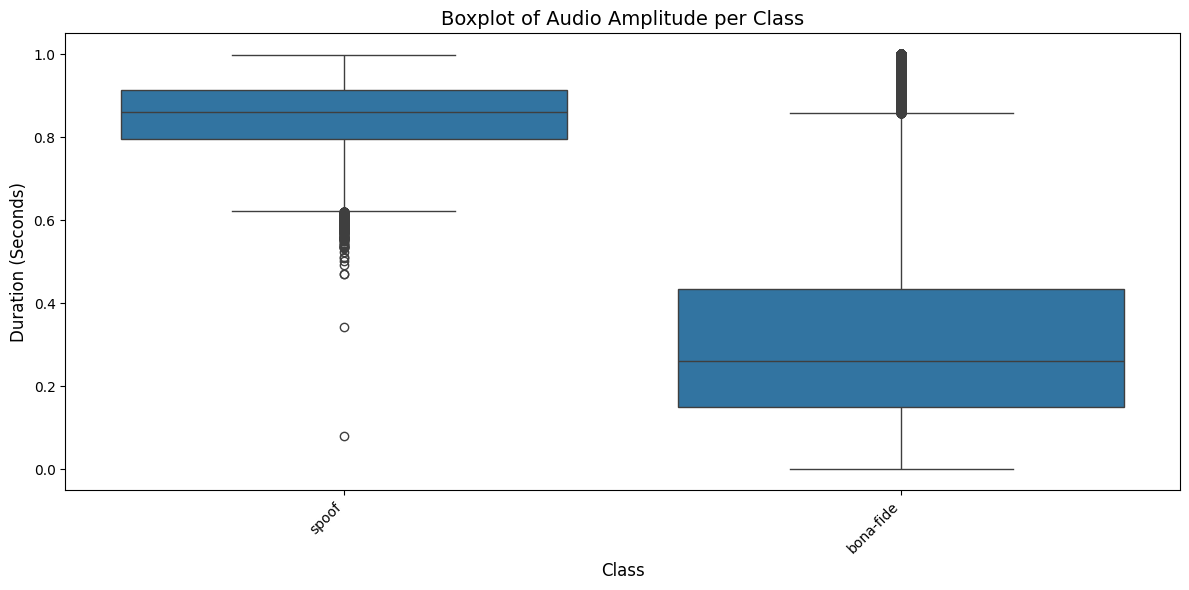

In [38]:
# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=dataset_metadata_df, x='label', y='amplitude')

# Customize the plot
plt.title("Boxplot of Audio Amplitude per Class", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Duration (Seconds)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

In [39]:
print("amplitude mean of each gender")
dataset_metadata_df.groupby("gender")['amplitude'].mean()

amplitude mean of each gender


gender
F    0.557053
M    0.550601
Name: amplitude, dtype: float32

In [40]:
print("amplitude mean of each class, divided by gender")
dataset_metadata_df.groupby(["label", "gender"])['amplitude'].mean()

amplitude mean of each class, divided by gender


label      gender
bona-fide  F         0.341880
           M         0.302686
spoof      F         0.825911
           M         0.876797
Name: amplitude, dtype: float32

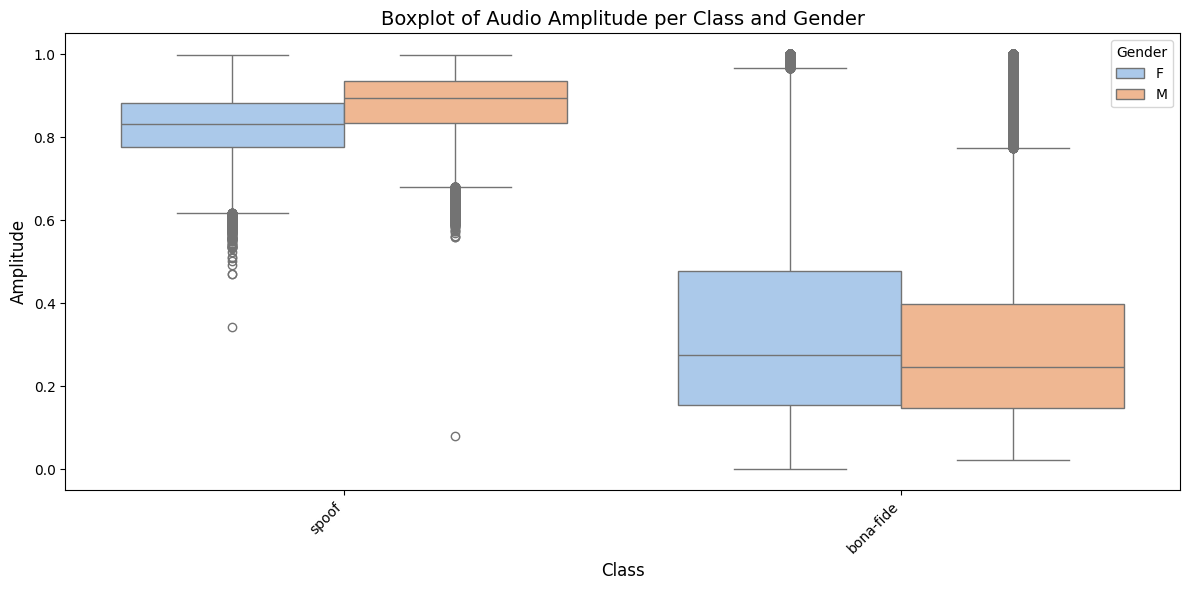

In [41]:
# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=dataset_metadata_df, x='label', y='amplitude', hue='gender', palette='pastel')

# Customize the plot
plt.title("Boxplot of Audio Amplitude per Class and Gender", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Amplitude", fontsize=12)
plt.legend(title="Gender")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

#### Parte 3.4: Análise do balanceamento <a class="anchor" id="part_03_04"></a>

##### Parte 3.4.1: Balanceamento por Classe

In [42]:
print("samples by class")
dataset_metadata_df['label'].value_counts()

samples by class


label
bona-fide    100998
spoof         78816
Name: count, dtype: int64

In [43]:
print("minutes by class")
dataset_metadata_df.groupby("label")['duration'].sum().sort_values(ascending=False) / 60

minutes by class


label
bona-fide    8679.425531
spoof        6054.537244
Name: duration, dtype: float64

In [44]:
print("duration mean of each class")
dataset_metadata_df.groupby("label")['duration'].mean()

duration mean of each class


label
bona-fide    5.156196
spoof        4.609118
Name: duration, dtype: float64

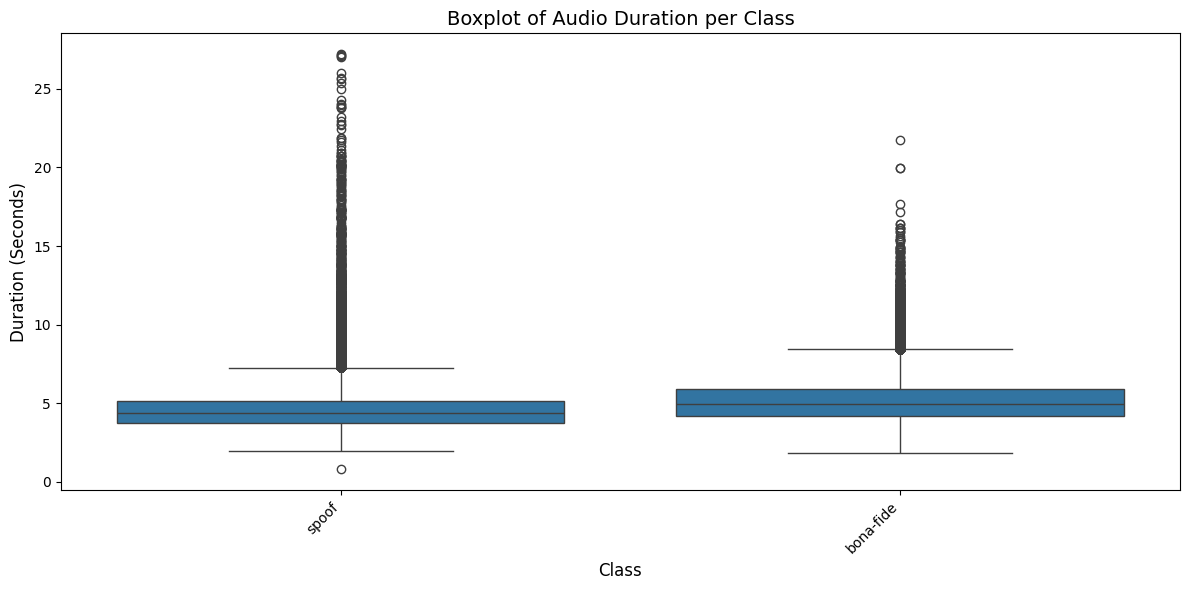

In [45]:
# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=dataset_metadata_df, x='label', y='duration')

# Customize the plot
plt.title("Boxplot of Audio Duration per Class", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Duration (Seconds)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

##### Parte 3.4.2: Balanceamento por Gênero

In [46]:
print("samples by gender")
dataset_metadata_df['gender'].value_counts()

samples by gender


gender
F    91813
M    88001
Name: count, dtype: int64

In [47]:
print("minutes by gender")
dataset_metadata_df.groupby("gender")['duration'].sum().sort_values(ascending=False) / 60

minutes by gender


gender
F    7597.340374
M    7136.622401
Name: duration, dtype: float64

In [48]:
print("duration mean of each gender")
dataset_metadata_df.groupby("gender")['duration'].mean()

duration mean of each gender


gender
F    4.964879
M    4.865824
Name: duration, dtype: float64

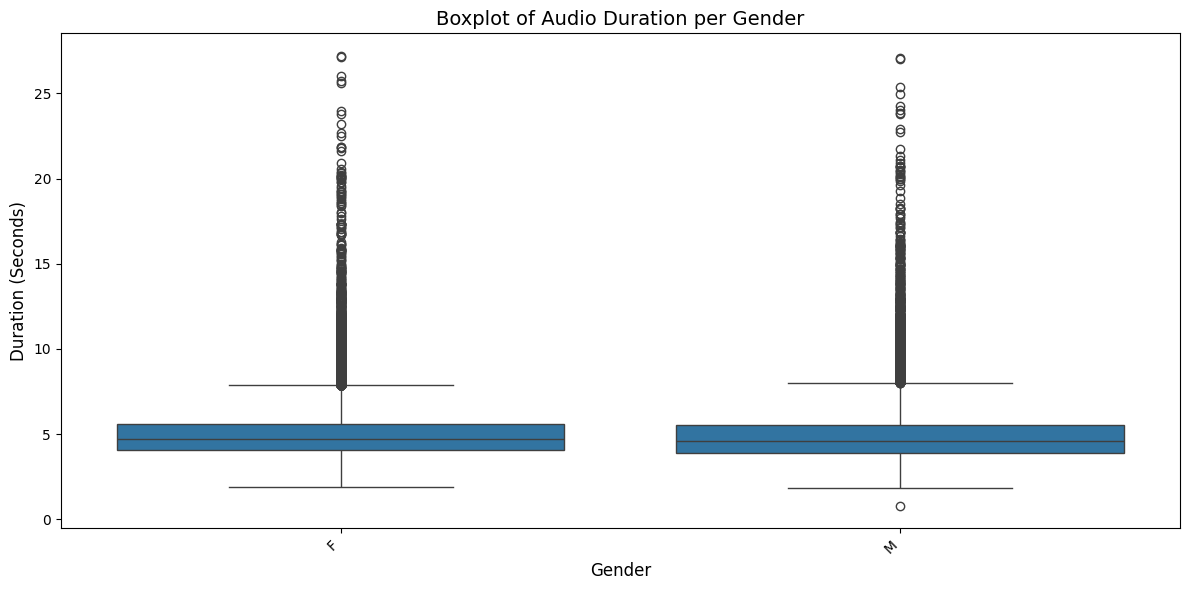

In [49]:
# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=dataset_metadata_df, x='gender', y='duration')

# Customize the plot
plt.title("Boxplot of Audio Duration per Gender", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Duration (Seconds)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

##### Parte 3.4.3: Balanceamento por Classe e Gênero

In [50]:
print("samples by class and gender")
dataset_metadata_df.groupby(['label', 'gender']).size()

samples by class and gender


label      gender
bona-fide  F         50998
           M         50000
spoof      F         40815
           M         38001
dtype: int64

In [51]:
print("minutes by class and gender")
dataset_metadata_df.groupby(["label", "gender"])['duration'].sum().sort_values(ascending=False) / 60

minutes by class and gender


label      gender
bona-fide  F         4372.173085
           M         4307.252446
spoof      F         3225.167289
           M         2829.369956
Name: duration, dtype: float64

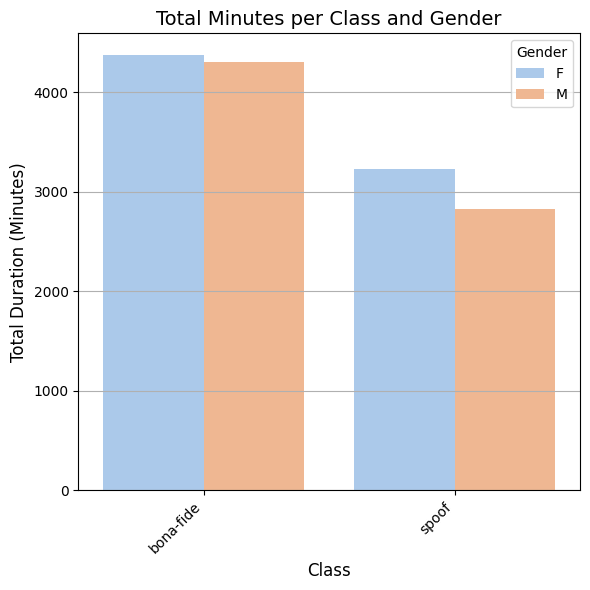

In [52]:
# Aggregate the data: Total duration grouped by class and gender, converted to minutes
grouped_data = dataset_metadata_df.groupby(['label', 'gender'])['duration'].sum().reset_index()
grouped_data['duration_minutes'] = grouped_data['duration'] / 60  # Convert to minutes

# Create the bar plot using Seaborn
plt.figure(figsize=(6, 6))
sns.barplot(
    data=grouped_data,
    x='label',  # Group by class
    y='duration_minutes',  # Total duration in minutes
    hue='gender',  # Separate bars by gender
    palette='pastel'
)

# Customize the plot
plt.title("Total Minutes per Class and Gender", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Total Duration (Minutes)", fontsize=12)
plt.legend(title="Gender")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()

# Show the plot
plt.show()

In [53]:
print("duration mean of each class and gender")
dataset_metadata_df.groupby(["label", "gender"])['duration'].mean()

duration mean of each class and gender


label      gender
bona-fide  F         5.143935
           M         5.168703
spoof      F         4.741150
           M         4.467309
Name: duration, dtype: float64

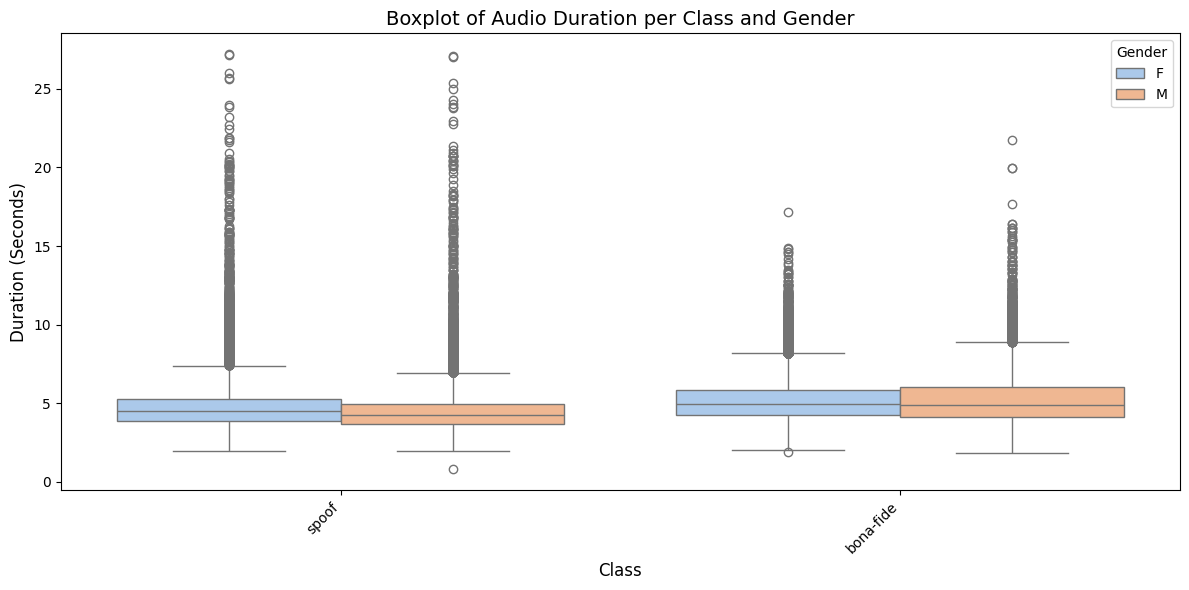

In [54]:
# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=dataset_metadata_df, x='label', y='duration', hue='gender', palette='pastel')

# Customize the plot
plt.title("Boxplot of Audio Duration per Class and Gender", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Duration (Seconds)", fontsize=12)
plt.legend(title="Gender")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

[Voltar ao topo](#topo)